# Table of Contents
* [1. Python dependencies](#1.-Python-dependencies)
	* [1.1 Picking up metadata for the samples belonging to the discovery set](#1.1-Picking-up-metadata-for-the-samples-belonging-to-the-discovery-set)
	* [1.2 Loading the expression data](#1.2-Loading-the-expression-data)
* [2. Implementing statistical model to predict the repeat length](#2.-Implementing-statistical-model-to-predict-the-repeat-length)
	* [2.1 Computing Pearson's correlation coefficient between any gene and repeat length](#2.1-Computing-Pearson's-correlation-coefficient-between-any-gene-and-repeat-length)
	* [2.2 Slicing and dicing a numpy array](#2.2-Slicing-and-dicing-a-numpy-array)
		* [2.2.1 That's how we can choose given samples from our array](#2.2.1-That's-how-we-can-choose-given-samples-from-our-array)
		* [2.2.2 That's how we can choose given genes from our array](#2.2.2-That's-how-we-can-choose-given-genes-from-our-array)
	* [2.3 Choosing top n genes and the training set from `probeset_data`](#2.3-Choosing-top-n-genes-and-the-training-set-from-probeset_data)
		* [2.3.1 Choosing the training set](#2.3.1-Choosing-the-training-set)
			* [2.3.1.1 Testing for off-by-one errors](#2.3.1.1-Testing-for-off-by-one-errors)
		* [2.3.2 Choosing top genes](#2.3.2-Choosing-top-genes)
		* [2.3.3 Splitting our data into training and testing indices](#2.3.3-Splitting-our-data-into-training-and-testing-indices)
		* [2.3.4 Rearranging repeat length](#2.3.4-Rearranging-repeat-length)
		* [2.3.5 Choosing top 500 genes](#2.3.5-Choosing-top-500-genes)
		* [2.3.6 Testing that labels are correctly assigned (not permuted)](#2.3.6-Testing-that-labels-are-correctly-assigned-%28not-permuted%29)
		* [2.3.7 Utility functions to change lists into row or column vectors](#2.3.7-Utility-functions-to-change-lists-into-row-or-column-vectors)
		* [2.3.8 Fitting the model](#2.3.8-Fitting-the-model)
		* [2.3.9 Carrying out predictions on the testing set and comparing them with the ground truth.](#2.3.9-Carrying-out-predictions-on-the-testing-set-and-comparing-them-with-the-ground-truth.)
	* [2.4 Viewing top correlating genes](#2.4-Viewing-top-correlating-genes)
	* [2.5 Combining defined utility functions into a single `simulation_step` function](#2.5-Combining-defined-utility-functions-into-a-single-simulation_step-function)
* [3. Running the simulation 5000 times to produce the scatter plot of predictions vs ground through](#3.-Running-the-simulation-5000-times-to-produce-the-scatter-plot-of-predictions-vs-ground-through)
	* [3.1 Running a simulation to compute the probability that a random predictor would achieve the same $r^2$ or better (estimating the p-value of null hypothesis that our predictor behaves like a random predictor).](#3.1-Running-a-simulation-to-compute-the-probability-that-a-random-predictor-would-achieve-the-same-$r^2$-or-better-%28estimating-the-p-value-of-null-hypothesis-that-our-predictor-behaves-like-a-random-predictor%29.)


# 1. Python dependencies

All of the python dependencies used in this replication study are standard python packages. You can download them either manually or using pip. Please ensure that your python version is 3.6, and `pip` is installing packages for the correct python distribution. Depending on your system and your particular setup, your `pip` executable may be actually named `pip3`, and its location may vary.

The safest option is to install an isolated python 3.6 environment using virtualenv, which on most systems can be accomplished using the following, or similar shell commands:

`pip install -r requirements.txt`

If you'd rather not install the dependencies on your machine, a docker container with the pipeline is provided. 
This container should work out-of-the-box on any platform supporting docker, which includes most modern linux, macOS and Windows distributions:

`todo give link to a docker container`

In [1]:

import os
import gzip
import numpy as np
from scipy.stats import pearsonr
from sklearn.cross_decomposition import PLSRegression
from matplotlib import pyplot as plt
import random
import bisect
import math
import json
%matplotlib inline

As we can see, the discovery set contains exactly 107 samples, which corresponds with data description given in the original study.

## 1.1 Picking up metadata for the samples belonging to the discovery set

## 1.2 Loading the expression data

In [124]:
experiment_data_path = os.path.join("blood_predictions", "blood_data")
probeset_IDs_path = os.path.join("blood_predictions", "blood_ids")
repeat_length_path = os.path.join("blood_predictions", "blood_rt")

In [125]:
with open(probeset_IDs_path) as f:
    probeset_IDs = json.load(f)

with open(repeat_length_path) as f:
    repeat_length = json.load(f)

with open(experiment_data_path) as f:
    probeset_data = np.loadtxt(experiment_data_path)


In [126]:
probeset_data.shape

(6687, 35)

In [127]:
assert(probeset_data.shape[1] == len(repeat_length))

Additionaly, the number of rows in the array should be equal to the number of probeset IDs

In [128]:
assert(probeset_data.shape[0] == len(probeset_IDs))

The expression data, and other relevant features are now loaded.

In [129]:
print(repeat_length)

[872, 297, 593, 408, 717, 1035, 373, 118, 280, 993, 740, 1111, 290, 654, 11, 261, 12, 571, 186, 1261, 1000, 345, 465, 604, 223, 12, 83, 12, 999, 13, 561, 77, 240, 866, 697]


In [130]:
probeset_data

array([[ 6.62527391,  6.54323474,  6.92312717, ...,  6.92252483,
         6.04437681,  6.51807009],
       [ 6.15447433,  6.06506798,  6.151056  , ...,  6.43976672,
         6.3336855 ,  6.16143317],
       [ 5.98443097,  6.15447433,  6.11740139, ...,  6.46908061,
         6.07109121,  6.17739869],
       ..., 
       [ 6.65063572,  6.49264168,  6.36715622, ...,  6.76578887,
         6.74227056,  6.61094115],
       [ 6.65267506,  6.5624323 ,  6.56685962, ...,  6.6854473 ,
         6.62319263,  6.40445258],
       [ 7.29536015,  6.95661391,  7.08079324, ...,  7.06268826,
         7.1331871 ,  7.17993743]])

In [131]:
probeset_IDs[:10]

['VEGFA_2908182_GTGCATTGGAGCCTTGCCTTGCTGC_chr6_+_43739005_43739029',
 'VEGFA_2908182_CTTTCTGCTGTCTTGGGTGCATTGG_chr6_+_43738989_43739013',
 'VEGFA_2908182_ACTTTCTGCTGTCTTGGGTGCATTG_chr6_+_43738988_43739012',
 'VEGFA_2908182_CCTTGCTGCTCTACCTCCACCATGC_chr6_+_43739021_43739045',
 'VEGFA_2908203_AGGACCTATGTCCTCACACCATTGA_chr6_+_43753337_43753361',
 'VEGFA_2908203_TGCTGCTAAATCACCGAGCCCGGAA_chr6_+_43752575_43752599',
 'VEGFA_2908203_CCCTTCCTGGGGTGCAGCCTAAAAG_chr6_+_43753314_43753338',
 'VEGFA_2908203_CAGCACGGTCCCTCTTGGAATTGGA_chr6_+_43752531_43752555',
 'VEGFA_2908194_CAAAGAAAGATAGAGCAAGACAAGA_chr6_+_43746628_43746652',
 'VEGFA_2908194_ACCAAAGAAAGATAGAGCAAGACAA_chr6_+_43746626_43746650']

# 2. Implementing statistical model to predict the repeat length

The original study describes the following approach to predict the repeat length from probeset data (mRNA profiles):
1. Split data randomly into training and testing set.
2. Select 500 best probesets using Pearson's $r^2$. Selection is to be done using only the training set.
3. Fit Partial Least Squares Regression (PLSR) model on the 500 selected probesets, again using only the training set data.
4. Predict repeat length on the testing set. Record both the actual and the predicted repeat length for each biological sample in the testing set.
5. Repeat steps 1-4 10 thousand times.
6. Compute $r^2$ of predicted repeat lengths vs actual repeat lengths.

What follows is our implementation of this procedure, split into functions, with each function accompanied by example usage, which build up into a single pass of the simulation (steps 1-5).

## 2.1 Computing Pearson's correlation coefficient between any gene and repeat length

Pearson's correlation is used in the original study to select the most highly correlated probesets.

In [132]:
r, p_value = pearsonr(repeat_length, probeset_data[0])
r, p_value

(-0.11519625829876298, 0.50992221317307407)

## 2.2 Slicing and dicing a numpy array

In the original study, only top $n$ correlated genes are used to carry out the predictions.

### 2.2.1 That's how we can choose three samples from our array

In [133]:
probeset_data[:, [0, 7, 10]]

array([[ 6.62527391,  6.97107882,  6.73872141],
       [ 6.15447433,  6.15919174,  5.88624994],
       [ 5.98443097,  6.00334957,  6.14954585],
       ..., 
       [ 6.65063572,  6.73437301,  6.63472777],
       [ 6.65267506,  6.26578568,  6.59781028],
       [ 7.29536015,  7.00589256,  7.17759915]])

In [134]:
probeset_data[:, [0, 7, 10]].shape

(6687, 3)

### 2.2.2 That's how we can choose three genes from our array

In [135]:
probeset_data[[0, 7, 1120], :].shape

(3, 35)

## 2.3 Choosing top n genes and the training set from `probeset_data`

We can use array slicing & dicing with the `random` module to choose the training set for cross-validation and feature selection.

### 2.3.1 Choosing the training set

For any pass of the simulation we're going to split our data into a training set and a testing set.

In [136]:
def choose_training_indicies(data, no_training_samples):
    """Return a partition of column indicies of the `data`
    matrix into two sets: `training_indicies, testing_indicies`.
    The training set will contain `no_training_samples` biological
    samples.
    """
    indices = list(range(data.shape[1]))
    random.shuffle(indices)
    training_indices = indices[:no_training_samples]
    test_indicies = indices[no_training_samples:]
    return training_indices, test_indicies

#### 2.3.1.1 Testing for off-by-one errors

In [137]:
27//2

13

In [138]:
a, b = choose_training_indicies(probeset_data, 17)
assert(sorted(a + b) == list(range(35)))

In [139]:
def split_data(data, training_indices, test_indices):
    """Return a partition of data into `training_set, testing_set`
    using an existing partition of column incidices into
    `training_indicies` and `test_indicies`
    """
    return data[:, training_indices], data[:, test_indices]

In [140]:
example_training, example_testing = split_data(probeset_data, a, b)

In [141]:
example_training.shape

(6687, 17)

In [142]:
example_testing.shape

(6687, 18)

### 2.3.2 Choosing top genes

In [143]:
def order_indicies(allele, data):
    """
    Return a sorted list of correlated genes, from the most to the least
    correlated. Each entry in the list is a tuple `r2, gene_index`, where
    `r2` denotes the correlation of gene expression and `allele`, and
    the index of the gene in the `data` matrix respectively.
    
    `allele` is the list of repeat lengths, with each repeat length
    corresponding to one column in `data`
    """
    r2s = []
    for i in range(data.shape[0]):
        gene_r, _ = pearsonr(allele, data[i])
        # We have to store both the gene and the gene index, to recover the indices after sorting.
        r2s.append((gene_r ** 2, i))
    r2s.sort()
    # This reverses the list, assuring decreasing order.
    r2s = r2s[::-1]
    return r2s

In [144]:
top_10 = order_indicies(repeat_length, probeset_data)[:10]

In [145]:
top_10

[(0.41862417330719792, 1527),
 (0.36592300298481728, 674),
 (0.34534938866347609, 702),
 (0.33007948219125915, 701),
 (0.32857319518018968, 1320),
 (0.32579481913308223, 3095),
 (0.31433569062209604, 1582),
 (0.30717177560001646, 2139),
 (0.27921673744179981, 1719),
 (0.27916307234462734, 6441)]

In [146]:
def choose_top_genes(indicies, data):
    """
    Take `indicies`, which is a list of ordered pairs
    `r2, column_index`, and a matrix of probeset data,
    `data`, and filter all rows to contain only genes on
    the `indicies` list.
    """
    just_indices = [i[1] for i in indicies]
    return data[just_indices, :]

In [147]:
choose_top_genes(top_10, probeset_data).shape

(10, 35)

### 2.3.3 Splitting our data into training and testing indices

For the sake of this example, we will split our data into 70 biological samples in the training set and 37 biological samples in the testing set

In [148]:
training_i, testing_i = choose_training_indicies(probeset_data, 70)
training_fold, testing_fold = split_data(probeset_data, training_i, testing_i)

In [149]:
training_fold.shape

(6687, 35)

In [150]:
testing_fold.shape

(6687, 0)

### 2.3.4 Rearranging repeat length

We have to do this to reintroduce 1-1 correspondence between a value of repeat length and a position in traing or testing set.

In [151]:
repeat_length_training = [repeat_length[i] for i in training_i]
repeat_length_testing = [repeat_length[i] for i in testing_i]

### 2.3.5 Choosing top 500 genes

To avoid double-dipping we choose top genes on the training fold.

In [152]:
top_500 = order_indicies(repeat_length_training, training_fold)[:500]

After filtering top genes from the training fold we change the name to `training_set`

In [153]:
training_set = choose_top_genes(top_500, training_fold)

In [154]:
testing_set = choose_top_genes(top_500, testing_fold)

In [155]:
training_set.shape

(500, 35)

In [156]:
testing_set.shape

(500, 0)

This achieves steps 1-2 of our pipeline.

### 2.3.6 Testing that labels are correctly assigned (not permuted)

In [157]:
repeat_length_first_row = list(zip(training_fold[0], repeat_length_training)) + list(zip(testing_fold[0], repeat_length_testing))

In [158]:
repeat_length_first_row.sort()

In [159]:
allele_first_row_actual = list(zip(probeset_data[0], repeat_length))
allele_first_row_actual.sort()

In [160]:
[i[1] for i in repeat_length_first_row] == [i[1] for i in repeat_length_first_row]

True

### 2.3.7 Utility functions to change lists into row or column vectors

In [161]:
def cv(lista):
    return np.matrix(lista).transpose()
def rv(lista):
    return np.matrix(lista)

### 2.3.8 Fitting the model

We can finally fit our model using the `training_set` and `repeat_length_training`.

In [162]:
plsr = PLSRegression(n_components=10, scale=False)
# we have to transpose the training set, as scikitlearn treats our 
plsr.fit(training_set.transpose(), cv(repeat_length_training))

PLSRegression(copy=True, max_iter=500, n_components=10, scale=False,
       tol=1e-06)

### 2.3.9 Carrying out predictions on the testing set and comparing them with the ground truth.

Our ground truth is known values of the repeat length.

In [163]:
results = plsr.predict(testing_set.transpose())
results = [i[0] for i in results]

ValueError: Found array with 0 sample(s) (shape=(0, 500)) while a minimum of 1 is required.

In [164]:
r, p_value = pearsonr(repeat_length_testing, results)
r, p_value

NameError: name 'results' is not defined

## 2.4 Viewing top correlating genes

While not strictly necessary, and not depended on anywhere else in the pipeline, this allows us to get additional numerical intuition about our data.

In [165]:
correlations = 3

In [166]:
top_correlations = order_indicies(repeat_length, probeset_data)[:correlations]

probeset ID: NFIX_3822182_AAAGCAAGAAAGGATGCAGAACTGC_chr19_+_13205751_13205775 r**2: 0.418624173307 Bonf Corr p: 0.178399237041
probeset ID: CAPZB_2399769_GAGATGGCGCTGTGCGGTCAATGAT_chr1_-_19665881_19665905 r**2: 0.365923002985 Bonf Corr p: 0.792209930917
probeset ID: CAPZB_2399768_AGAGAACTGAGAGCGAGGTGTGGCA_chr1_-_19665805_19665829 r**2: 0.345349388663 Bonf Corr p: 1.37585052268


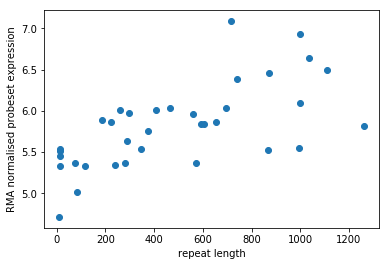

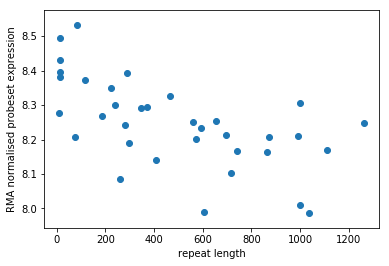

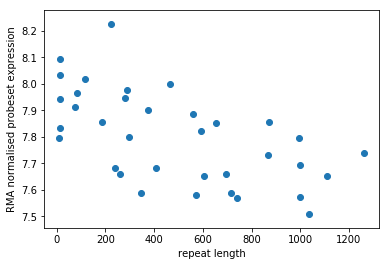

In [236]:
for i in range(correlations):
    f = plt.figure()
    columnI = top_correlations[i][1]
    print("probeset ID:", probeset_IDs[columnI], "r**2:", top_correlations[i][0], "Bonf Corr p:", pearsonr(repeat_length, probeset_data[[columnI], :][0])[1] * probeset_data.shape[0])
    plt.scatter(repeat_length, probeset_data[[columnI], :])
    plt.xlabel("repeat length")
    plt.ylabel("RMA normalised probeset expression")

## 2.5 Combining defined utility functions into a single `simulation_step` function

Finally, we can wrap all of the examples in this chapter into a single function, which will execute one pass of the simulation (steps 1-4).

In [168]:
def simulation_step(training_size=97, no_probes=500, n_components=10):
    """Execute a full step of the simulation, and return a tuple consisting of two lists:
    predicted repeat lengths, and the ground truth repeat lengths
    """
    training_i, testing_i = choose_training_indicies(probeset_data, training_size)
    training_fold, testing_fold = split_data(probeset_data, training_i, testing_i)
    repeat_length_training = [repeat_length[i] for i in training_i]
    repeat_length_testing = [repeat_length[i] for i in testing_i]
    
    top_500 = order_indicies(repeat_length_training, training_fold)[:no_probes]
    training_set = choose_top_genes(top_500, training_fold)
    testing_set = choose_top_genes(top_500, testing_fold)

    plsr = PLSRegression(n_components=n_components)
    
    plsr.fit(training_set.transpose(), cv(repeat_length_training))
    
    results = plsr.predict(testing_set.transpose())
    results = [i[0] for i in results]

    return repeat_length_testing, results

This is an example of results obtained from a single pass

In [169]:
a, b = simulation_step(training_size=17, no_probes=500, n_components=10)

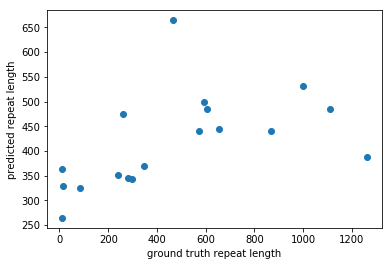

In [170]:
plt.scatter(a, b)
plt.xlabel("ground truth repeat length")
plt.ylabel("predicted repeat length")

# 3. Running the simulation 1000 times to produce the scatter plot of predictions vs ground truth

Equipped with the tools built in the previous chapter we can now execute the final bits of the analysis: running each simulation step 10 thousand times, while recording predicted and ground truth repeat length at each stage.

The authors of the original study carry out this final stage for multiple choice of different parameters. However, they conclude that limiting the analysis to top 500 probesets allows to achieve good predictions.

In [237]:
real_alleles = []
simulated_alleles = []
for i in range(10):
    real_allele, simulated_allele = simulation_step(training_size=35//2, no_probes=500, n_components=2)
    real_alleles += real_allele
    simulated_alleles += simulated_allele

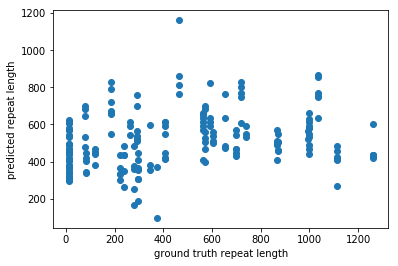

In [238]:
plt.scatter(real_alleles, simulated_alleles)
r, p_value = pearsonr(real_alleles, simulated_alleles)
plt.xlabel("ground truth repeat length")
plt.ylabel("predicted repeat length")

In [239]:
r, p_value = pearsonr(real_alleles, simulated_alleles)

In [240]:
r

0.22863015001604128

As we can see, there is a modest correlation between our predictions and the ground truth, consistent with the findings of the original study.

In [241]:
r**2

0.05227174549635754

## 3.1 Running a simulation to compute the probability that a random predictor would achieve the same $r^2$ or better (estimating the p-value of null hypothesis that our predictor behaves like a random predictor).

Finally we have to ask how likely it is that a random predictor would achieve $r^2$ as high or higher. We define a random predictor to be a predictor, which samples its output uniformly from our sample's repeat length, without any knowledge of the mRNA profile.

In [242]:
r2s = []
sim = 100000
for i in range(sim):
    repeat_length_random = repeat_length[:]
    random.shuffle(repeat_length_random)
    inter_r, p_value = pearsonr(repeat_length, repeat_length_random)
    r2s.append(inter_r**2)
r2s.sort()
print(1 - bisect.bisect_right(r2s, r**2)/float(sim))

0.18667
